In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import metrics
import scipy
import seaborn as sns

(0.0, 1000.0, -115.15935301845307, 105.59050559577385)

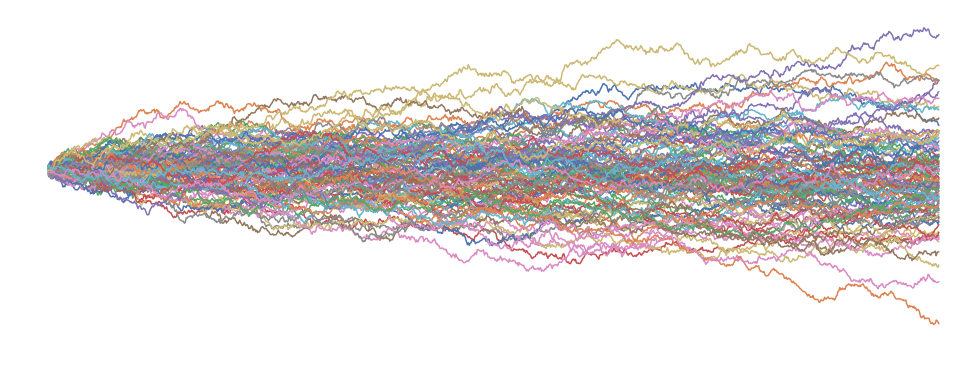

In [2]:
def sim_random_walk(n):
    eps = np.random.normal(size=n)
    return np.cumsum(eps)

n = 1000
sns.set(style='white')
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
plt.xlim(0, n)
for _ in range(100):
    ax.plot(sim_random_walk(n))
    
ax.axis('off')

/opt/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


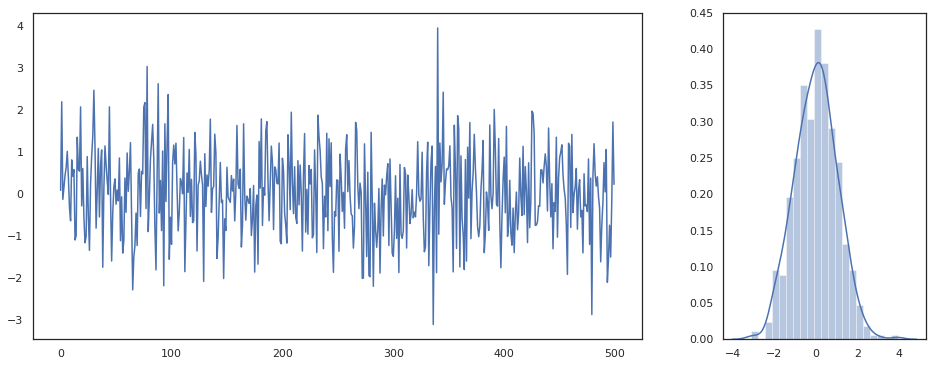

In [3]:
np.random.seed(18)
n = 500
fig, ax = plt.subplots(1,2, figsize=(16, 6), gridspec_kw={'width_ratios':[3, 1]})
eps = np.random.normal(size=n)
ax[0].plot(eps)
sns.distplot(eps, ax=ax[1])

In [4]:
def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]

    return x, y

lag_view(np.arange(10), 3)[0]

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8]])

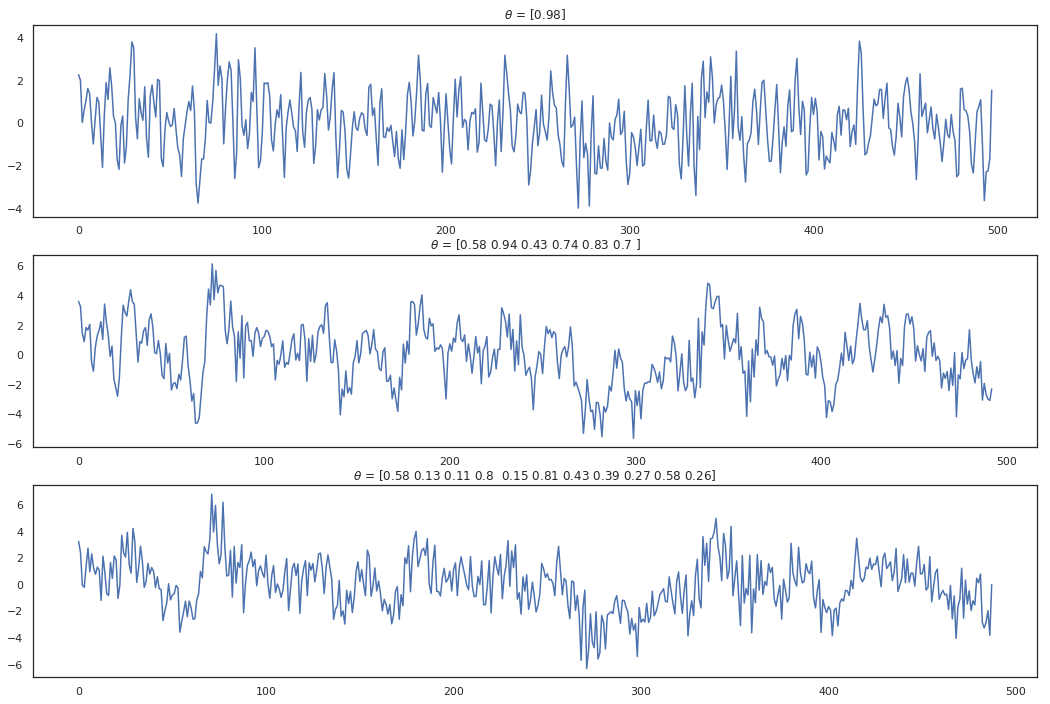

In [5]:
def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    eps_q, _ = lag_view(eps, len(theta))
    return eps_q @ theta

fig = plt.figure(figsize=(18, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    theta = np.random.uniform(0, 1, size=i + 1)
    plt.subplot(a)
    plt.title(f'$\\theta$ = {theta.round(2)}')
    plt.plot(ma_process(eps, theta))

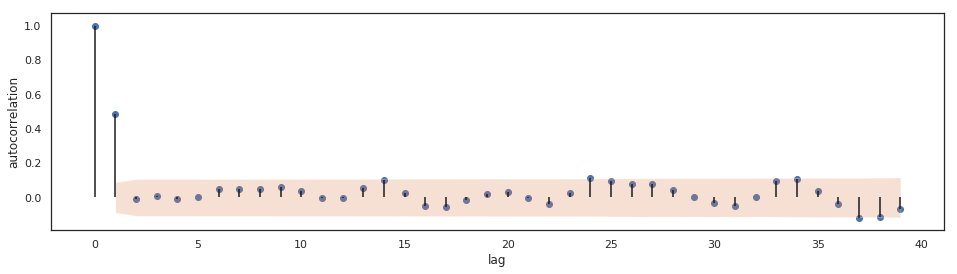

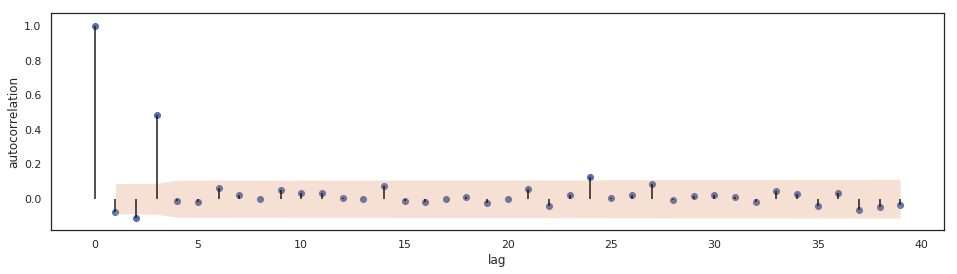

In [6]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

def acf(x, lag=40):
    """
    Determine auto correlation factors.
    :param x: (array) Time series.
    :param lag: (int) Number of lags.
    """
    return np.array([1] + [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)])

lag = 40
# Create an ma(1) and an ma(2) process.
ma_1 = ma_process(eps, [1])
ma_2 = ma_process(eps, [0.2, -0.3, 0.8])



def bartletts_formula(acf_array, n):
    """
    Computes the Standard Error of an acf with Bartlet's formula
    Read more at: https://en.wikipedia.org/wiki/Correlogram
    :param acf_array: (array) Containing auto correlation factors
    :param n: (int) Length of original time series sequence.
    """
    # The first value has autocorrelation with it self. So that values is skipped
    se = np.zeros(len(acf_array) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_array[1:-1]**2)) / n )
    return se


def plot_acf(x, alpha=0.05, lag=40, title=None):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    acf_val = acf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(acf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

for array in [ma_1, ma_2]:
    plot_acf(array)


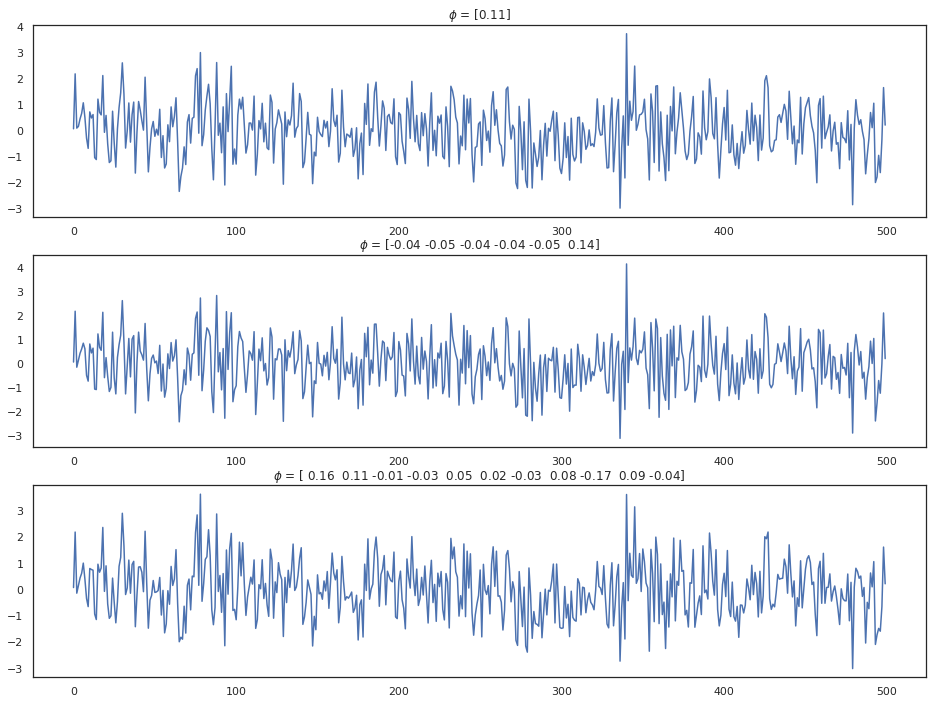

In [7]:
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1] 
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

fig = plt.figure(figsize=(16, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    phi = np.random.normal(0, 0.1, size=i + 1)
    plt.subplot(a)
    plt.title(f'$\\phi$ = {phi.round(2)}')
    plt.plot(ar_process(eps, phi))

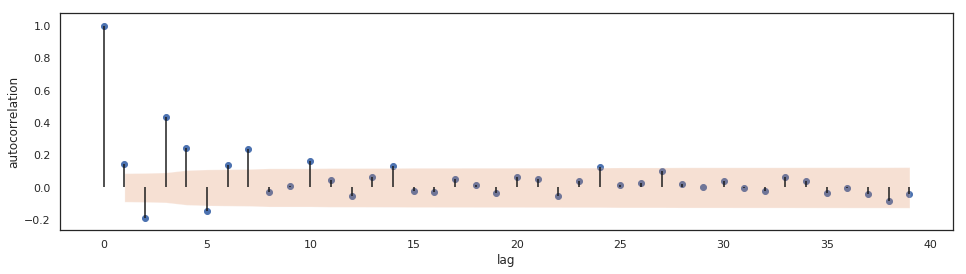

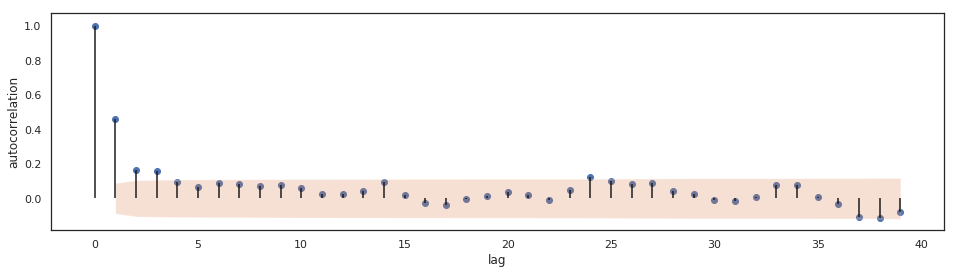

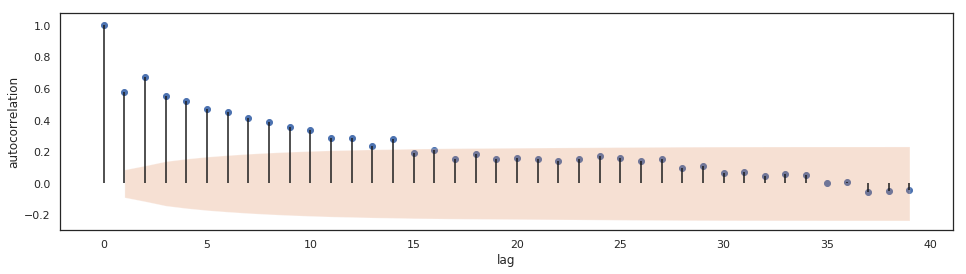

In [8]:
plot_acf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_acf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_acf(ar_process(eps, [0.2, 0.5, 0.1]))

# Ordinary least squares

$$y = \beta X + \epsilon$$

$$\beta = (X^T X)^{-1} X^T y$$

In [19]:
def least_squares(x, y):
    return np.linalg.inv((x.T @ x)) @ (x.T @ y)

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None
    
    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x
    
    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta
        
    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

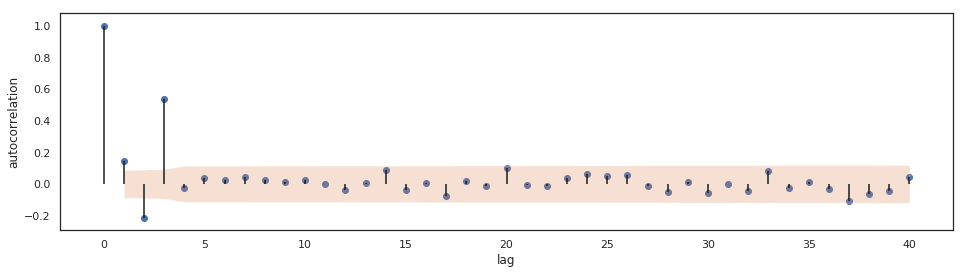

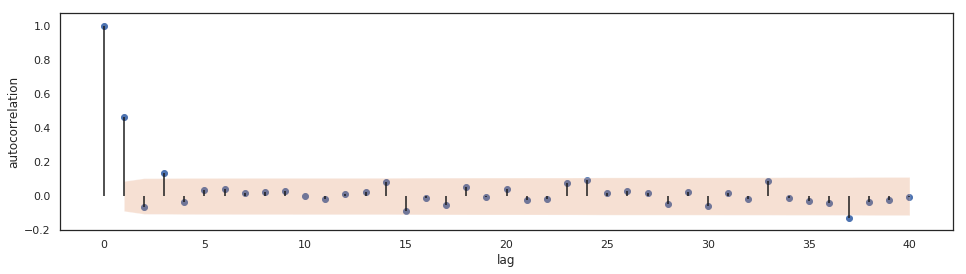

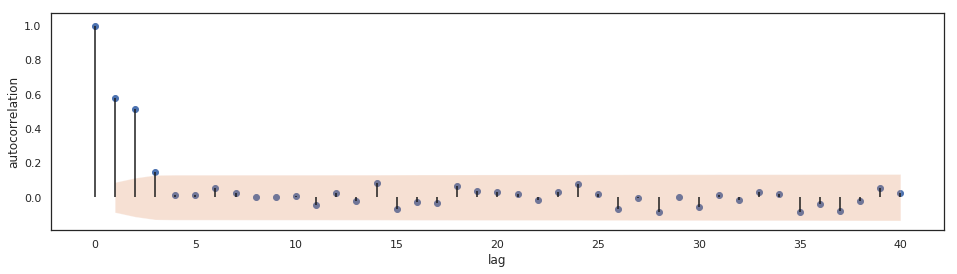

In [10]:

def pacf(x, lag=40):
    """
    Partial auto correlation function.
    
    pacf results in:
        [1, acf_lag_1, pacf_lag_2, pacf_lag_3]
    :param x: (array)
    :param lag: (int)
    """
    y = []
    
    # Partial auto correlation needs intermediate terms.
    # Therefore we start at index 3
    for i in range(3, lag + 2):
        backshifted = lag_view(x, i)[0]

        xt = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        xt_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt)

        xt_k = backshifted[:, -1]
        xt_k_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt_k)

        y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat))
    return np.array([1, acf(x, 2)[1]] +  y)

def plot_pacf(x, alpha=0.05, lag=40, title=None):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    pacf_val = pacf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

plot_pacf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_pacf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_pacf(ar_process(eps, [0.2, 0.5, 0.1]))

In [112]:
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)
    
def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)
    
difference(np.arange(10)[::-1])

array([ 9, -1, -1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
def bic_score():
         return (-2 * self.score(X) * X.shape[0] +
                self._n_parameters() * np.log(X.shape[0]))

7.772423301589858

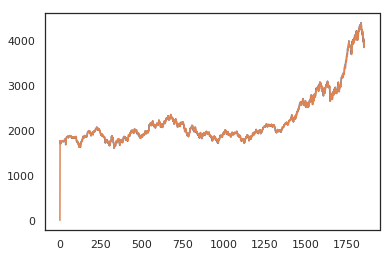

In [274]:
class AR(LinearModel):
    def __init__(self, p, fit_intercept=True):
        """
        An AR model.
        :param p: (int)
        """
        super().__init__(fit_intercept)
        self.p = p
        self.resid = None
        self.variance = None
        
    def prepare_features(self, x):
        features, x = lag_view(np.r_[np.zeros(self.p), x], self.p)
        return features, x
        
    def fit_predict(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return self.predict(x, prepared=(features, x))
        
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features and x
        """
        features, x = kwargs.get('prepared', self.prepare_features(x))
        y = super().predict(features)
        self.resid = x - y
        self.variance = np.mean(self.resid**2)
        return y
    
    @property
    def bic(self):
        n = len(self.resid)
        return np.log(self.variance) + len(self.beta) * np.log(n) / n
    
    @property
    def aic(self):
        return np.log(self.variance) + 2 * len(self.beta) / len(self.resid)
    
p = 2
m = AR(p)
pred = m.fit_predict(x)

plt.plot(x)
plt.plot(pred)

m.aic

In [113]:
class ARIMA(LinearModel):
    def __init__(self, q, d, p, fit_intercept=True):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        :param fit_intercept: (bool)
        """
        super().__init__(fit_intercept)
        self.p = p
        self.d = d
        self.q = q
        self.m = None
        self.sigma = 1
        
    def prepare_features(self, x):
        """
        Prepare eps_t and X_t-k features for the linear model.
        """
        if self.d > 0:
            x = difference(x, self.d)
        eps = np.random.normal(scale=self.sigma, size=len(x))

        ar_features = None
        ma_features = None
        if self.q > 0:
            # create features by shifting the window of `order` size by one step.
            ma_features = lag_view(eps, self.q + 1)[0]
            # Now eps_t is not included
            ma_features = ma_features[:, :-1]
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ma_features, ar_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
            
        eps_t = eps[self.q: n + self.q]
        return features, eps_t, x[:n]
    
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        # move eps_t to left side of the equation. 
        # This needs to be corrected when predicting
        features, eps_t, x = self.prepare_features(x)
        x = x - eps_t
        super().fit(features, x)
        return self.predict(x, prepared=(features, eps_t, x))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features, eps_t, x = kwargs.get('prepared', self.prepare_features(x))
        y = super().predict(features) + eps_t
        if self.d > 0:
            y += undo_difference(x, self.d) 
        return y
         
q = 0
d = 1
p = 1


m = ARIMA(q, d, p, 0, 1)
pred = m.fit_predict(x)
print(m.coef_)
# print(m.intercept_, m.coef_)

# print(x.shape, pred.shape)

a = 0
b = -1
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.plot(x[a:b])
ax.plot(pred[a:b])

# results.plot_predict(ax=ax)

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

None [0.553 0.001]


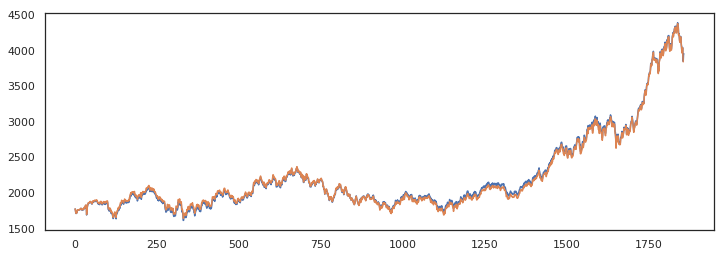

In [229]:
class ARIMA(LinearModel):
    def __init__(self, q, d, p, fit_intercept=True, sigma=1):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        :param fit_intercept: (bool)
        :param sigma: (flt) Standard deviation of the epsilon terms.
        """
        super().__init__(fit_intercept)
        self.p = p
        self.d = d
        self.q = q
        self.m = None
        self.sigma = sigma
        
    def prepare_features(self, x):
        """
        Prepare eps_t and X_t-k features for the linear model.
        """
        if self.d > 0:
            x = difference(x, self.d)
        eps = np.random.normal(scale=self.sigma, size=len(x))

        ar_features = None
        ma_features = None
        if self.q > 0:
            # create features by shifting the window of `order` size by one step.
            ma_features = lag_view(eps, self.q + 1)[0]
            # Now eps_t is not included
            ma_features = ma_features[:, :-1]
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ma_features, ar_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
            
        eps_t = eps[self.q: n + self.q]
        return features, eps_t, x[:n]
    
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        # move eps_t to left side of the equation. 
        # This needs to be corrected when predicting
        features, eps_t, x = self.prepare_features(x)
        x = x - eps_t
        super().fit(features, x)
        return self.predict(x, prepared=(features, eps_t, x))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features, eps_t, x = kwargs.get('prepared', self.prepare_features(x))
        y = super().predict(features) + eps_t
        if self.d > 0:
            y += undo_difference(x, self.d) 
        return y
         
q = 1
d = 1
p = 1


m = ARIMA(q, d, p, 0, 1)
pred = m.fit_predict(x)
print(m.intercept_, m.coef_.round(3))

# print(x.shape, pred.shape)

a = 0
b = -1
plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.plot(x[a:b])
ax.plot(pred[a:b])

# results.plot_predict(ax=ax)

In [53]:
x = sm.datasets.get_rdataset('EuStockMarkets').data['CAC'].values

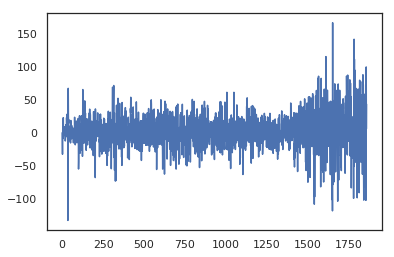

In [54]:
plt.plot(difference(x))

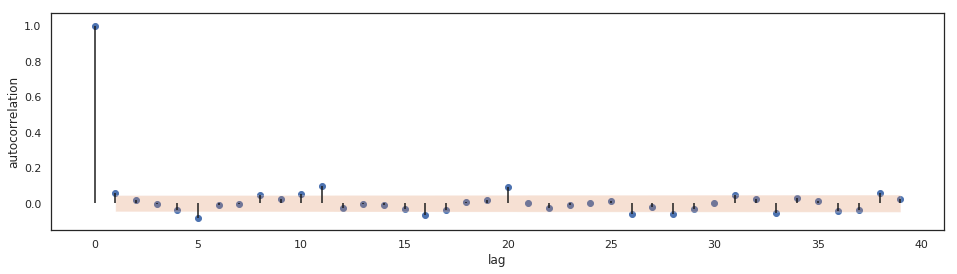

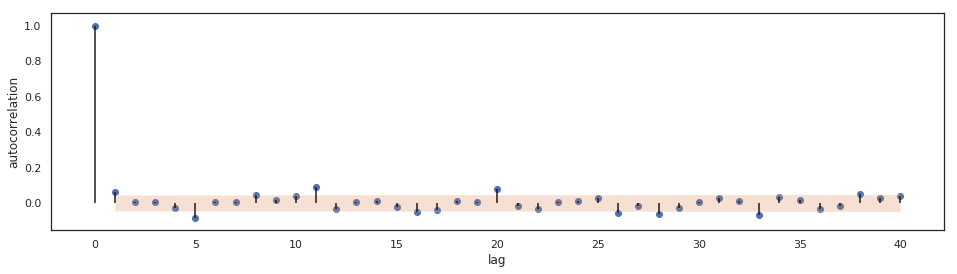

In [40]:
plot_acf(difference(x))
plot_pacf(difference(x))

In [201]:
m = sm.tsa.ARIMA(x, (p, d, q))
m.k_constant

0

[ 1.19571639  0.11652559 -0.08376277]


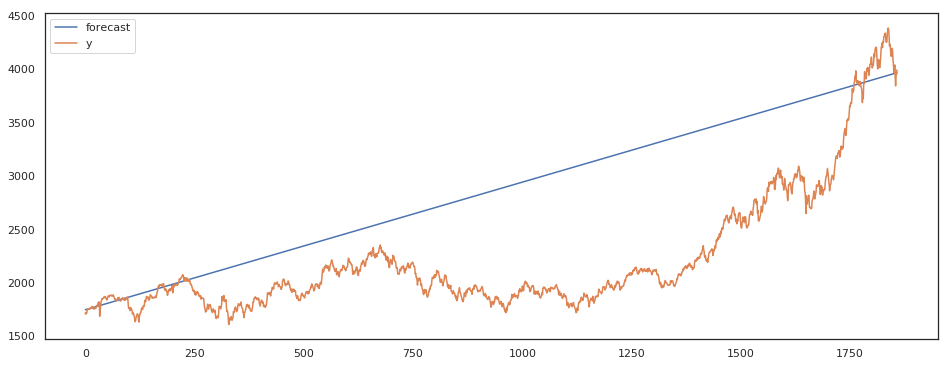

In [214]:
q = 1
d = 1
p = 1

results = sm.tsa.ARIMA(x, (p, d, q)).fit()
print(results.params)

plt.figure(figsize=(16, 6))
ax = plt.subplot(111)
pred_sm = results.plot_predict(ax=ax, dynamic=True)
# m = ARIMA(q, d, p, 1)
# pred = m.fit_predict(x)
# print(m.coef_)

# plt.figure(figsize=(12,4))
# plt.plot(x)
# plt.plot(pred)

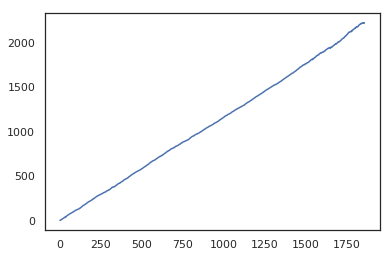

In [157]:
plt.plot(undo_difference(pred_sm, 1))

In [96]:
print(sm.datasets.sunspots.NOTE)

::

    Number of Observations - 309 (Annual 1700 - 2008)
    Number of Variables - 1
    Variable name definitions::

        SUNACTIVITY - Number of sunspots for each year

    The data file contains a 'YEAR' variable that is not returned by load.



In [72]:
data = sm.datasets.sunspots.load_pandas().data

In [73]:
data.index = pd.Index(sm.tsa.datetools.dates_from_range('1700', '2008'))
del data['YEAR']

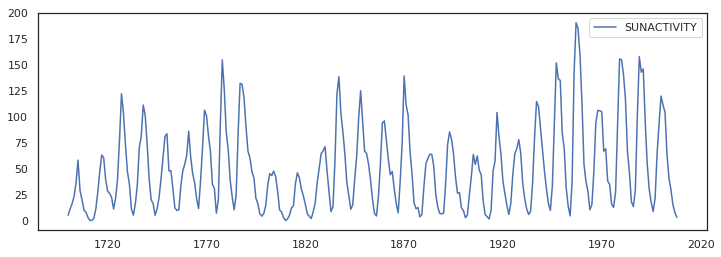

In [74]:
data.plot(figsize=(12, 4))
x = data.values.squeeze()

# Moveing average model MA(q)

$$ X_t = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} ... + \theta_q \epsilon_{q} $$

where $\epsilon$ is white noise:

$$\epsilon \sim N(0, \alpha)$$

$\alpha$ is a hyperparameter



# ARIMA model

The mathematical definition of the ARIMA model is equal to that of the ARMA model.

**ARMA(p, q)** _(AutoRegressive, Moving Average)_

$$X_t = c + \epsilon_t + \sum_{i=1}^{p}{\phi_i X_{t - i}} + \sum_{i = 1}^q{\theta_i \epsilon_{t-i}} $$


To convert this to an ARIMA model:

**ARIMA(p, d, q)** _(AutoRegressive Integrated Moving Average)_

$$X^*_t = c + \epsilon_t + \sum_{i=1}^{p}{\phi_i X^*_{t - i}} + \sum_{i = 1}^q{\theta_i \epsilon_{t-i}} $$

Where $X^*$ is the integrated time series $X$ $d$ times

The term integrated implies that in order to obtain a forecast of $X$, we have to sum up (or integrate over) the values of $X^*$ because $X^*$ are the differenced values of the original series $X$.If no differencing is involved, this model is called an Autoregressive Moving Average [ARMA(p,q)] with p and q retaining their original meaning and no d.






In [100]:
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.concatenate((np.zeros(1), np.diff(x)))
        return difference(x, d - 1)
    
def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)

# print(difference(a, 2))

# print(difference(a, 3))
# print(undo_difference(difference(a, 3), 3))

In [101]:
# np.cumsum(difference(a, 2))

68.2529386667413 [-0.21150225 -0.26660066 -0.38434853 -0.36914932 -0.41741958 -0.36728083]


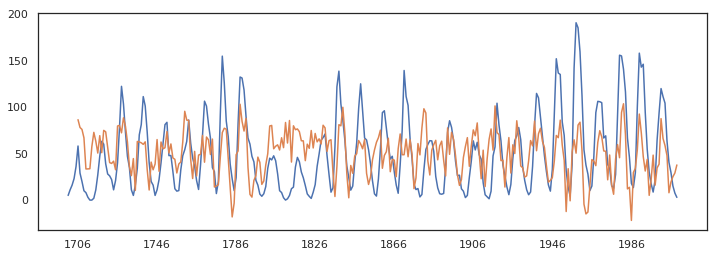

In [108]:
def init_eps(order, y, sigma=None):
    sigma = y.std() / 3 if sigma is None else sigma
    return np.random.normal(0, sigma, size=(y.shape[0]))

def create_ar_features(x, order):
    """
    Create the features for AR model.
    
    The features are [X_t-1, X_t-2 ... X_t-k] and the labels are X_t
    So the features are shifted by one time step compared to the time step we want to predict.
    """
    y = x.copy()
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # Reverse the array as we started at the end and remove duplicates.
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    x = np.stack(x)[::-1][order - 1: -1]
    y = y[order:]
    
    return x, y

def create_ma_features(eps, order, y=None):
    eps = np.array([eps[-(i + order):][:order] for i in range(y.shape[0])])
    eps = np.stack(eps)[::-1][order - 1:]
    # eps_t is known when predicting x_t so the labels are in the same phase /lag
    # as the features eps.
    if y is not None:
        y = y[order - 1:]    
        return eps, y
    else: 
        return eps


# https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model 
def ar_model(y, eps, order=2):
    x, y = create_ra_features(y)    
    
    # Move eps_t to other side of equation
    add = eps[:y.shape[0]]
    y -= add
    
    m = linear_model.LinearRegression(fit_intercept=True)
    m.fit(x, y)
    
    return m.predict(x) + add, m


class ARIMA:
    def __init__(self, p, d, q, sigma=None):
        self.p = p
        self.d = d
        self.q = q
        self.m = None
        self.sigma = sigma
        
    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)
        eps = init_eps(self.q, x)
        
        x_ = None
        ma_features = ar_features = np.zeros((x.shape[0], 1))
        if self.q > 0:
            # Add features for `order` + 1. Later this will be eps_t
            ma_features, x_ = create_ma_features(eps, self.q + 1, x)
        if self.p > 0:
            ar_features, x = create_ar_features(x, self.p)
        x = x if x_ is None or len(x) < len(x_) else x_
        del x_
            
        eps = eps[:x.shape[0]]
        ma_features = ma_features[:x.shape[0]]
        ar_features = ar_features[:x.shape[0]]
        eps_t = ma_features[:, :1]
        ma_features = ma_features[:, 1:]
        return np.hstack((ma_features, ar_features)), eps_t.ravel(), x
        
    def fit_predict(self, x): 
        # move eps_t to left side of the equation
        
        features, eps_t, x = self.prepare_features(x)

        x = x - eps_t
        model = LinearModel()
        model.fit(features, x)
        self.m = model
        return self.predict(x, prepared=(features, eps_t, x))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features, eps_t, x = kwargs.get('prepared', self.prepare_features(x))

        x = self.m.predict(features) + eps_t
        if self.d > 0:
            x += undo_difference(x, self.d)
        return x
    
    def generate(self, n, ma_w=None, ar_w=None):
        
        t = np.arange(n)
        if self.q:
            eps = np.random.normal(0, 1, size=n)
            feat = create_ma_features(eps)
        
        
        
        
q = 5
d = 0
p = 1

m = ARIMA(p, d, q, sigma=30)
pred = m.fit_predict(x)
print(m.m.intercept_, m.m.coef_)
# print(m.RA.intercept_)
# m.RA.coef_

plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(data.index[data.shape[0] - pred.shape[0]:], pred)

/opt/miniconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


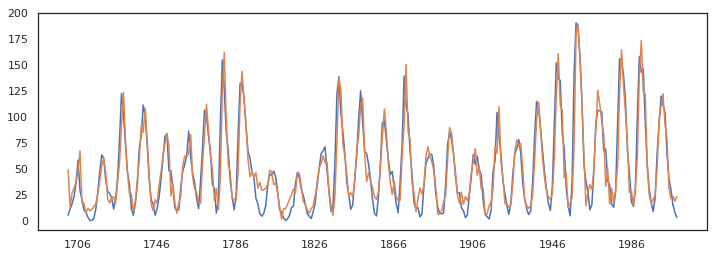

In [237]:
p = 5
q = 2
d = 0
results = sm.tsa.ARIMA(data.copy(), (p, d, q)).fit()
plt.figure(figsize=(12,4))
plt.plot(data)

pred = results.model.predict(results.params, dynamic=False)

plt.plot(data.index[:pred.shape[0]], pred)

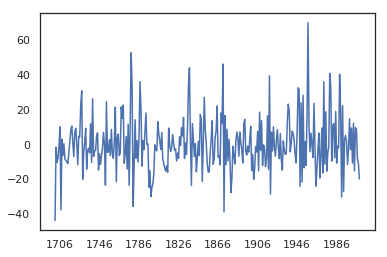

In [238]:
plt.plot(results.resid)

# Autocorrelation

Let's look how autocorrelation is defined. First we make a function that computes the Pearson correlation between two sequences that are assumed to come from a Normal distribution.

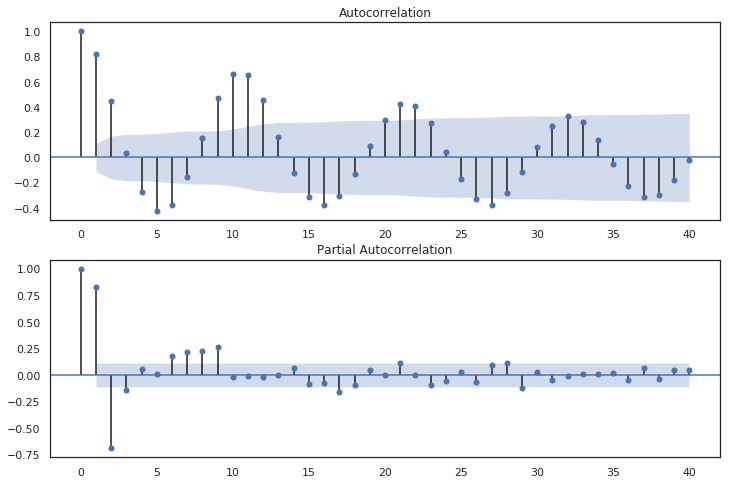

In [239]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.values.squeeze(), lags=40, ax=ax)
ax = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.values.squeeze(), lags=40, ax=ax)

In [240]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())
    
pearson_correlation(x, x + np.random.randn(x.shape[0]))

0.9996781213197145

The autocorrelation is the correlation between the sequence with the current last value truncated at the end `x[:-i]` and the sequence with a certain amount of lag `x[:i]`.

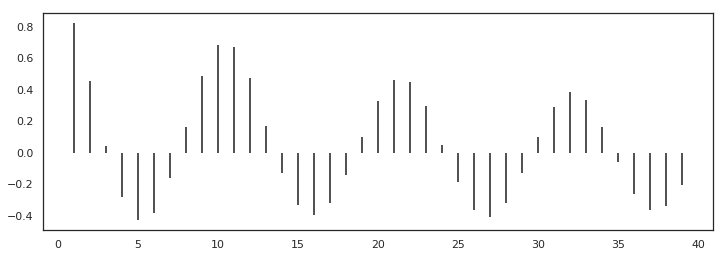

In [241]:
def plot(x, lag=40):
    plt.figure(figsize=(12, 4))
    corr = [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)]
    plt.vlines(np.arange(1, lag), 0, corr)
    plt.show()
plot(x)

# Partial autocorrelation

The partial correlation between $BX$ and $B^kX$  where $B$ is the backshift operator.

$$BX_t = X_{t-1} $$

can be determined as follows.

Let $\hat{BX}$ and $\hat{B^kX}$ be determined by a Linear Model conditioned on $ B^2X ... B^{k -1} $ parameterized by $\beta$ and $\phi$.

$$\hat{BX} \sim \beta_2 B^2X + \beta_3 B^3X ... \beta_{k-1} B^{k -1}X $$ 

$$\hat{B^kX} \sim \phi_2 B^2X + \phi_3 B^3X ... \phi_{k-1} B^{k -1}X $$ 

The partial correlation is then defined by the Pearsons coefficient of the residuals of both predicted values $\hat{BX}$ and $\hat{B^kX}$.

$$ pcf = corr(BX - \hat{BX} , B^kX - \hat{B^kX} ) $$

In [242]:
backshifted = create_ar_features(x, 4)[0]
backshifted[:3]

array([[ 5., 11., 16., 23.],
       [11., 16., 23., 36.],
       [16., 23., 36., 58.]])

Correlation of $X_{t-1}$, $X_{t-2} ... X_{t-n}$

In [251]:
def pcaf(x, lag=40):
    y = []
    for i in range(3, lag):
        backshifted = create_ar_features(x, i)[0]

        bx = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        bx_hat = LinearModel(fit_intercept=True).fit_predict(feat, bx)

        bkx = backshifted[:, -1]
        bkx_hat = LinearModel(fit_intercept=True).fit_predict(feat, bkx)

        y.append(pearson_correlation(bx - bx_hat, bkx - bkx_hat))
    return y

y = pcaf(x)

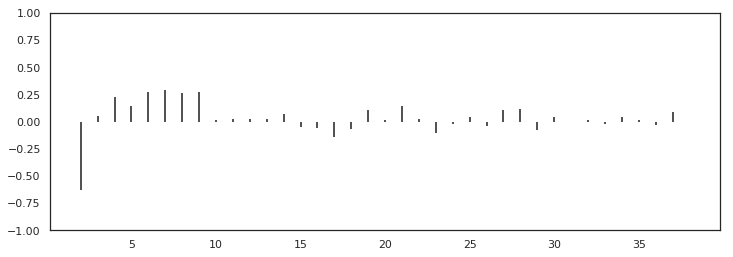

In [244]:
def plot_autocorrelation(x, lag=40, biased=False):
    y = []
    for i in range(3, lag):
        backshifted = create_ar_features(x, i)[0]

        bx = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        bx_hat = LinearModel(fit_intercept=False).fit_predict(feat, bx)

        bkx = backshifted[:, -1]
        bkx_hat = LinearModel(fit_intercept=False).fit_predict(feat, bkx)

        y.append(pearson_correlation(bx - bx_hat, bkx - bkx_hat))

    plt.figure(figsize=(12, 4))
    plt.ylim(-1, 1)
    plt.vlines(np.arange(0, len(y)) + 2, 0, y)
plot_autocorrelation(x, 40)

In [ ]:
y = 

array([ 1.   ,  0.823, -0.69 , -0.141,  0.056,  0.005,  0.182,  0.22 ,
        0.228,  0.263, -0.016, -0.008, -0.015, -0.001,  0.062, -0.083,
       -0.079, -0.162, -0.091,  0.045,  0.002,  0.113, -0.001, -0.099,
       -0.057,  0.023, -0.066,  0.097,  0.111, -0.126,  0.025, -0.048,
       -0.011,  0.005,  0.009,  0.02 , -0.048,  0.069, -0.041,  0.045,
        0.048])

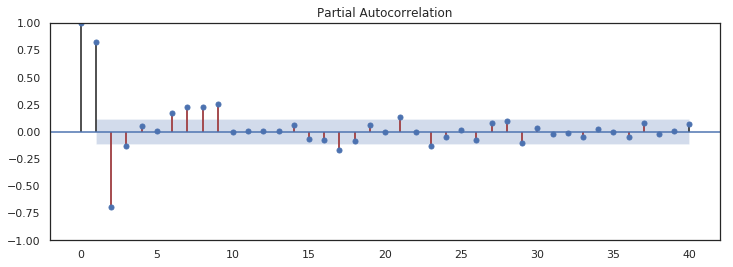

In [252]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(111)
ax.set_ylim(-1, 1)
sm.graphics.tsa.plot_pacf(x, lags=40, ax=ax, method='ols')

ax.vlines(np.arange(0, len(y)) + 2, 0, y, color='r')

sm.tsa.pacf(data).round(3)



|   :) | AR(p)                  | MA(q)                  | ARMA(p, q) |
|------|----------------------- |------------------------|------------|
| ACF  | Tails off              | Cuts off after lag $q$ | Tails off  |
| PACF | Cuts off after lag $p$ | Tails off              | Tails off  |

